In [24]:
import numpy as np 
import torch 
import math 
import matplotlib.pyplot as plt
from torch.optim import Optimizer
import time
#from SVR_optimizers import SAGA,SAG,SVRG
from tqdm import tqdm 
import seaborn as sns

In [2]:
%load_ext autoreload

%autoreload 2

In [8]:
N_samples = 100
p = 100
d = 40

In [9]:
X = torch.randn(N_samples, d)
true_beta = torch.randn(d,p)
true_alpha = torch.randn(d, p)
Y = X@true_beta + torch.randn(N_samples, p) 
Y_bis = X@true_alpha + torch.randn(N_samples,p) 

In [53]:
def get_prior_batch(X,Y,batch_size,p): 
    '''
    get the batches required to do a  minibatch gradient ascent.  

    args : 
            'batch_size' int.  the batch size you want. 

    returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                since the rest of the division is not always 0)
    '''
    #np.random.seed(2)
    n = Y.shape[0]
    indices = np.arange(n)
    indices = np.random.choice(indices, n, p = p,replace = True )
    #np.random.shuffle(indices)
    # get the number of batches and the size of the last one. 
    nb_full_batch, last_batch_size  = n//batch_size, n % batch_size  
    for i in range(nb_full_batch): 
        yield   (X[indices[i*batch_size: (i+1)*batch_size]],
                 Y[indices[i*batch_size: (i+1)*batch_size]],
                 Y_bis[indices[i*batch_size: (i+1)*batch_size]],
                 indices[i*batch_size: (i+1)*batch_size]
                )
    if last_batch_size != 0 :
        yield   (X[indices[-last_batch_size:]], Y[indices[-last_batch_size:]],
                  Y_bis[indices[-last_batch_size:]],indices[-last_batch_size:],
                )
        
        
def get_batch(X,Y,batch_size): 
    '''
    get the batches required to do a  minibatch gradient ascent.  

    args : 
            'batch_size' int.  the batch size you want. 

    returns : a generator. Will generate n/batch_size samples of size batch_size (except the last one 
                since the rest of the division is not always 0)
    '''
    #np.random.seed(2)
    n = Y.shape[0]
    indices = np.arange(n)
    np.random.shuffle(indices)
    # get the number of batches and the size of the last one. 
    nb_full_batch, last_batch_size  = n//batch_size, n % batch_size  
    for i in range(nb_full_batch): 
        yield   (X[indices[i*batch_size: (i+1)*batch_size]],
                 Y[indices[i*batch_size: (i+1)*batch_size]],
                 Y_bis[indices[i*batch_size: (i+1)*batch_size]],
                 indices[i*batch_size: (i+1)*batch_size]
                )
    if last_batch_size != 0 :
        yield   (X[indices[-last_batch_size:]], Y[indices[-last_batch_size:]],
                  Y_bis[indices[-last_batch_size:]],indices[-last_batch_size:],
                )
        


l  <seaborn.axisgrid.FacetGrid object at 0x7f9b7be09f40>


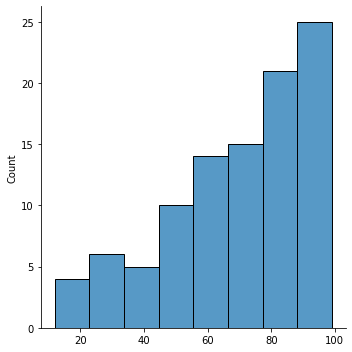

In [67]:
l = np.array([])
p = np.random.randn(N_samples)**2 + np.arange(N_samples)
p/=np.sum(p)
for x_b, y_b, y_b_bis, indices in get_prior_batch(X,Y, 8, p):
    l = np.concatenate((l, np.array([indices]).squeeze()), axis = 0)


In [6]:
def f(x,y_i): 
    return 1/2*torch.norm(x@beta-y_i)**2

def F(beta): 
    return 1/2*torch.mean(torch.norm(Y-X@beta, dim = (1))**2)

def F_bis(alpha): 
    return 1/2*torch.mean(torch.norm(Y_bis-X@alpha, dim = (1))**2)
def grad_f(beta,y_i,x_i): 
    return -torch.outer(x_i, y_i-x_i@beta)
def grad_f_bis(alpha,y_i,x_i): 
    return -torch.outer(x_i, y_i-x_i@beta)

def grad_F(beta): 
    return -torch.mean(torch.matmul(X.unsqueeze(2), (Y-X@beta).unsqueeze(1)) , axis = 0)
def grad_F_bis(alpha): 
    return -torch.mean(torch.matmul(X.unsqueeze(2), (Y_bis-X@alpha).unsqueeze(1)) , axis = 0)
    
def batch_grad(beta,x_batch, y_batch): 
    return -torch.matmul(x_batch.unsqueeze(2), (y_batch-x_batch@beta).unsqueeze(1))
def batch_grad_bis(alpha,x_batch, y_batch): 
    return -torch.matmul(x_batch.unsqueeze(2), (y_batch-x_batch@alpha).unsqueeze(1))


def fit(SAGA_bool, SVRG_bool, nb_step, choice_optim, lr, batch_size):
    beta = torch.zeros((d,p),requires_grad = True) + true_beta
    beta = torch.clone(true_beta) + torch.randn(d,p)
    beta.requires_grad_(True)
    alpha = torch.zeros((d,p), requires_grad = True) + true_alpha
    alpha = torch.clone(true_alpha) + torch.randn(d,p)
    alpha.requires_grad_(True)
    if SAGA_bool == False : 
        optim = choice_optim([alpha,beta], lr = lr)
    else : 
        optim = choice_optim([alpha,beta], lr, N_samples)
    MSE_alpha_list = []
    MSE_beta_list = []
    running_times = []
    t0 = time.time()
    for i in tqdm(range(nb_step)):
        if SVRG_bool:
            optim.update_mean_grad([grad_F_bis(alpha).detach(),grad_F(beta).detach()])
            alpha.old_param = torch.clone(alpha)
            beta.old_param = torch.clone(beta)
        for x_b,y_b,y_b_bis, selected_indices in get_batch(X,Y, batch_size): 
            batch_grad_alpha = batch_grad(alpha, x_b,y_b_bis)+torch.randn(batch_size, d,p)/1.5
            alpha.grad = torch.mean(batch_grad_alpha, axis = 0)
            
            batch_grad_beta = batch_grad(beta, x_b, y_b) + torch.randn(batch_size,d,p)/1.5
            beta.grad = torch.mean(batch_grad_beta, axis = 0)
            
            if SVRG_bool : 
                alpha.old_grad = torch.mean(batch_grad(alpha.old_param, x_b,y_b_bis), axis = 0)
                beta.old_grad = torch.mean(batch_grad(beta.old_param, x_b, y_b), axis = 0)
                
            if SAGA_bool : 
                t = time.time()
                optim.step([batch_grad_alpha,batch_grad_beta], selected_indices)
                #print('time SAGA full update ', time.time()- t)
            else : 
                t = time.time()
                optim.step()
                #print('time others', time.time()-t)
            MSE_alpha_list.append(torch.mean((alpha-true_alpha)**2).item())
            MSE_beta_list.append(torch.mean((beta-true_beta)**2).item())
            running_times.append(time.time()-t0)
            
        
    return MSE_alpha_list, MSE_beta_list, running_times

100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


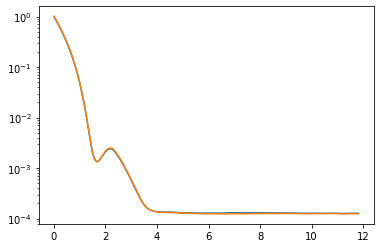

MSE_alpha 0.00012775727940606886
MSE_beta 0.00012584130381583237


In [68]:
MSE_alpha_SAG, MSE_beta_SAG, running_SAG = fit(True,False, 15, SAG, 0.008,100)
show(MSE_alpha_SAG, MSE_beta_SAG, running_SAG)
print('MSE_alpha', np.mean(MSE_alpha_SAG[-200:]))
print('MSE_beta', np.mean(MSE_beta_SAG[-200:]))

100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


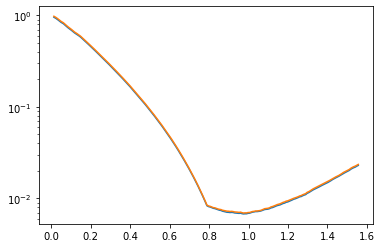

MSE_alpha 0.13533891117665917
MSE_beta 0.138452089948114


In [69]:
MSE_alpha_SAGA, MSE_beta_SAGA, running_SAGA = fit(True,False,  2, SAGA, 0.008, 100)
show(MSE_alpha_SAGA, MSE_beta_SAGA, running_SAGA)
print('MSE_alpha', np.mean(MSE_alpha_SAGA[-200:]))
print('MSE_beta', np.mean(MSE_beta_SAGA[-200:]))

100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


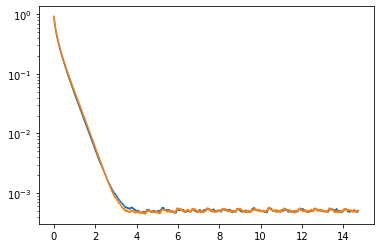

MSE_alpha 0.0005090455361641944
MSE_beta 0.0005075992067577318


In [70]:
MSE_alpha_torch, MSE_beta_torch, running_torch = fit(False,False, 20, torch.optim.RMSprop, 0.008, 100)
show(MSE_alpha_torch, MSE_beta_torch, running_torch)
print('MSE_alpha', np.mean(MSE_alpha_torch[-200:]))
print('MSE_beta', np.mean(MSE_beta_torch[-200:]))

100%|██████████| 30/30 [00:24<00:00,  1.21it/s]


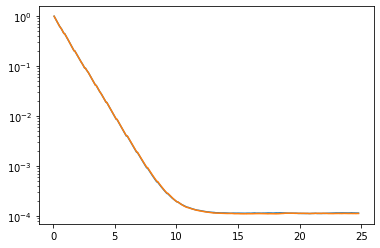

MSE_alpha 0.000115408957026375
MSE_beta 0.00011265208180702757


In [71]:
MSE_alpha_SVRG, MSE_beta_SVRG, running_SVRG = fit(False,True,  30, SVRG, 0.004, 100)
show(MSE_alpha_SVRG, MSE_beta_SVRG, running_SVRG)
print('MSE_alpha', np.mean(MSE_alpha_SVRG[-200:]))
print('MSE_beta', np.mean(MSE_beta_SVRG[-200:]))

In [35]:
def show(MSE_alpha_list, MSE_beta_list, running_times): 
    plt.plot(running_times, MSE_alpha_list)
    plt.plot(running_times, MSE_beta_list)
    plt.yscale('log')
    plt.show()

shape torch.Size([300, 4, 10])
dims : [torch.Size([4, 10]), torch.Size([4, 10])]
MSE :  tensor(0.0440, grad_fn=<MeanBackward0>)
MSE :  tensor(0.0694, grad_fn=<MeanBackward0>)


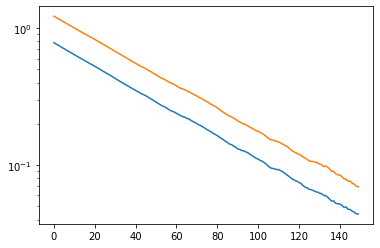

In [116]:
alpha = torch.zeros(d,p,requires_grad = True)
beta = torch.zeros(d,p ,requires_grad = True)
init_grad_alpha = batch_grad(alpha, X, Y_bis)
init_grad_beta = batch_grad(beta, X, Y)
init_grads = [init_grad_alpha, init_grad_beta]
saga = SAGA([alpha,beta],init_grads, 0.01)
MSE_alpha_list = []
MSE_beta_list = []
for i in range(5): 
    for x_b,y_b,y_b_bis, selected_indices in get_batch(X,Y, 10): 
        batch_grad_alpha = batch_grad(alpha, x_b,y_b_bis)
        batch_grad_beta = batch_grad(beta, x_b, y_b)
        alpha.grad = torch.mean(batch_grad_alpha, axis = 0)
        beta.grad = torch.mean(batch_grad_beta, axis = 0)
        saga.step([batch_grad_alpha,batch_grad_beta], selected_indices)
        MSE_alpha_list.append(torch.mean((alpha-true_alpha)**2))
        MSE_beta_list.append(torch.mean((beta-true_beta)**2))
        
plt.plot(np.arange(0, len(MSE_alpha_list)), MSE_alpha_list)
plt.plot(np.arange(0, len(MSE_beta_list)), MSE_beta_list)
plt.yscale('log')
print('MSE : ', MSE_alpha_list[-1])
print('MSE : ', MSE_beta_list[-1])
#saga.step(1)

In [70]:
y = torch.zeros((15,4), requires_grad = True)
y_bis = torch.zeros((8,6), requires_grad = True)

In [71]:
true_alpha

tensor([[ 0.2914,  0.9492, -0.3462,  0.5065, -1.1999, -1.0172,  1.2064,  0.6506,
         -1.5739,  0.8133],
        [-0.4434,  1.1968,  0.2454, -0.5643,  0.9045, -0.3705,  1.6797,  1.3262,
          1.4530, -1.0903],
        [ 0.0062, -0.0218, -1.2418, -0.8894, -1.1913,  0.6112,  0.0321,  0.8183,
         -1.2064,  0.4688],
        [-0.4059, -0.3626,  0.5432,  1.2395, -0.5273,  0.8417,  0.5511, -1.4600,
          0.3286,  0.3510]])

In [73]:
first_init = torch.cat((2*(y-2).unsqueeze(0), 2*(y-1).unsqueeze(0), 2*(y-4).unsqueeze(0)),0)
second_init = torch.cat((2*(y_bis-2).unsqueeze(0), 2*(y_bis-1).unsqueeze(0), 2*(y_bis-4).unsqueeze(0)),0)
print(first_init.shape)
init_grads = [first_init, second_init]

torch.Size([3, 15, 4])
